In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import math
from mpl_toolkits import mplot3d

In [3]:
def read_dataset(path=None, train_numbers=0):
    if path is None:
        path = "./midterm"
    subpaths = os.listdir(path)
    dataset = []
    labels = []
    # 读取所有数据并打上标签
    for subpath in subpaths:
        file = open(path + "/" + subpath)
        texts = file.readlines()
        file.close()
        data = [text.split() for text in texts]
        dataset.append(data)
        label = ['class' + subpath[4:5]] * len(data)
        labels.append(label)
    dataset = np.asfarray(dataset)
    # 选择部分数据作为训练数据，部分作为测试数据
    if train_numbers <= 0:
        return dataset, labels
    train_dataset = dataset[:, :train_numbers, :]
    test_dataset = dataset[:, train_numbers:, :]
    train_labels = [labels[i][:train_numbers] for i in range(len(labels))]
    test_labels = [labels[i][train_numbers:] for i in range(len(labels))]
    return (train_dataset, train_labels), (test_dataset, test_labels)

def scatter(data, marker, color, label):
    if data.shape[1] == 2:
        data = data.T
    plt.scatter(data[0], data[1], marker=marker, color=color, label=label)
    plt.legend()

def scatter_all_cate(dataset, labels, colors, nums=None):
    if nums is None:
        nums = len(dataset[0])
    for i in range(len(dataset)):
        scatter(dataset[i][:nums], '+', colors[i], labels[i][0])

def show_density(dataset, densities):
    densities = np.expand_dims(densities, axis=-1)
    fig = plt.figure(figsize=(12,10))
    ax1 = plt.axes(projection='3d')
    for i in range(3):
        zd = densities[i].T
        xd = dataset[i][:, 0:1].reshape(zd.shape)
        yd = dataset[i][:, 1:2].reshape(zd.shape)
        ax1.scatter(xd, yd, zd, c=colors[i])

In [4]:
class MLE:

    def fit(self, train_dataset, train_labels):
        """
        train_dataset: shape: (len_of_cates=3, len_of_dataset, dim=2)
        """
        # 先验概率，出现某一类别的概率，因为各种类点数相同，所以每个为1/3
        # prior = {'class1': 0.333, 'class2': 0.333, ...}
        cate = [label[0] for label in train_labels]
        prior = [len(label) / (train_dataset.size//2) for label in train_labels] 
        self.prior = dict([(cate, prior) for (cate, prior) in zip(cate, prior)])
        # 类别：{'class1', 'class2', 'class3'}
        self.cates = cate

        # 条件概率密度，某一类别下，出现某个点的概率，假设为二维正态分布模型
        # 即求出最大似然估计量，每个种类由两组参数，均值mu和协方差矩阵sig
        self.mus = [np.mean(train_dataset[i], axis=0).reshape((1, 2)) for i in range(len(cate))] # [mu1, mu2, mu3], mu is a matrix
        self.sigs = [np.cov(train_dataset[i].T).reshape((2, 2)) for i in range(len(cate))]       # [sig1, sig2, sig3], sig is a matrix
        
        # 计算各个条件概率密度 p(x|w)
        self.densities = [self.exp2d(mu, sig, x) for (mu, sig, x) in zip(self.mus, self.sigs, train_dataset)]
        # (len_of_dataset, 1)
        return self.densities
        
    def predict(self, test_dataset, test_labels=None):
        """
        test_dataset: shape(len_of_cate=3, len_of_dataset)
        """
        results = [] # shape(cate, len_of_dataset, 1)
        # test_densities = [self.exp2d(mu, sig, x) for (mu, sig, x) in zip(self.mus, self.sigs, test_dataset)]
        for data in test_dataset:
            # data: (len, 2)
            # 遍历每一个类别的数据集，计算p(w|x)，忽略归一化因子 = p(x|w)*P(w) = p(x|w)*(1/3)
            # 每一个数据点算出3个后验概率，所以posts: (3, len, 1)
            densities = [self.exp2d(mu, sig, data) for (mu, sig) in zip(self.mus, self.sigs)] # 三个类别的概率密度
            posts = np.array([density * self.prior[cate] for density, cate in zip(densities, self.cates)]) # 判别函数（后验概率）
            # print(posts[1]-posts[2])
            # 最大后验概率决策，选择后验概率最大的作为结果
            result = np.argmax(posts, axis=0)
            results.append(result)    
        result_labels = [[self.cates[i] for i in result.flatten()] for result in results]
        
        if test_labels is None:
            # 只需预测，不需给出统计数据
            return result_labels
        else:
            # 给出误判率等统计数据
            numeric_labels = [[self.cates.index(label) for label in labels] for labels in test_labels]
            numeric_labels = np.array(numeric_labels)
            results = np.array(results).reshape(numeric_labels.shape)
            # 正确的标签值相同，相减后为0，统计非0值得个数，即为错误率
            differ = results - numeric_labels
            mis_class = [np.count_nonzero(dif) / dif.size for dif in differ ]
            total_mis = sum(mis_class) / len(mis_class)
            mis = dict([(label, mis) for (label, mis) in zip(self.cates, mis_class)])
            return result_labels, mis, total_mis
    
    @classmethod
    def exp2d(cls, mu, sig, x):
        """
        mu: shape: (1, 2)
        sig: shape: (2, 2)
        x: shape: (len_of_dataset, dim=2)
        """
        scale = (1 / (math.pi * 2)) * (1 / (math.sqrt(np.linalg.det(sig))))  
        temp = (x-mu).dot(np.linalg.inv(sig))
        temp = np.array([u.T.dot(v) for u, v in zip(temp, x-mu)])
        index = -0.5*temp
        index = index.reshape((index.size, 1))
        return scale* np.exp(index)

MLE(训练数据1000条)各类别误判率： {'class1': '13.40%', 'class2': '2.50%', 'class3': '13.00%'}
总误判率： 9.63%


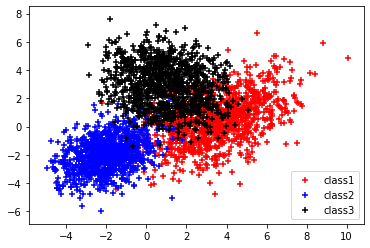

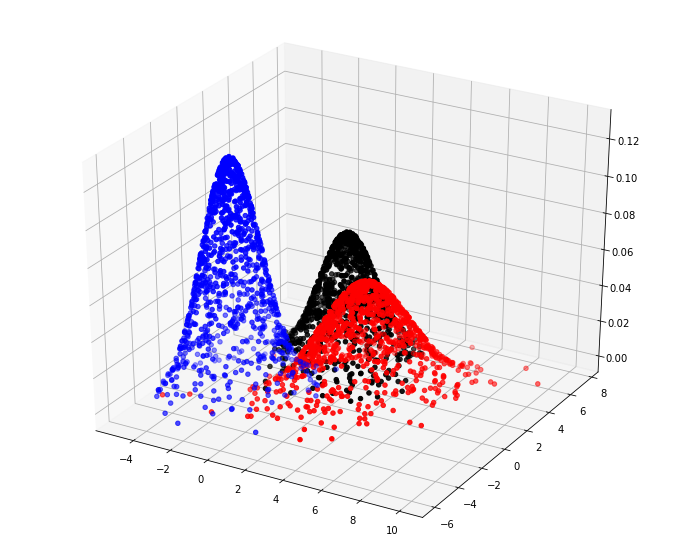

In [5]:
(train_dataset, train_labels), (test_dataset, test_labels) = read_dataset(train_numbers=1000)
colors = ('red', 'blue', 'black')
scatter_all_cate(train_dataset, train_labels, colors)

mle1 = MLE()
densities = mle1.fit(train_dataset, train_labels)
results, mis, total_mis = mle1.predict(test_dataset, test_labels)
show_density(train_dataset, densities)
print("MLE(训练数据1000条)各类别误判率：", dict([(k, "{:.2%}".format(v)) for k, v in mis.items()]))
print("总误判率：", "{:.2%}".format(total_mis))
plt.show()

MLE(训练数据500条)各类别误判率： {'class1': '12.87%', 'class2': '2.47%', 'class3': '13.67%'}
总误判率： 9.67%


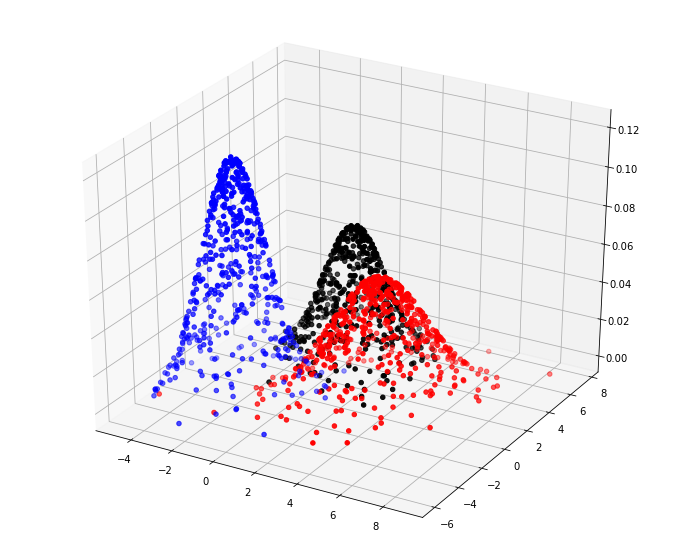

In [7]:
(train_dataset, train_labels), (test_dataset, test_labels) = read_dataset(train_numbers=500)

mle2 = MLE()
densities = mle2.fit(train_dataset, train_labels)
results, mis, total_mis = mle2.predict(test_dataset, test_labels)
show_density(train_dataset, densities)
print("MLE(训练数据500条)各类别误判率：", dict([(k, "{:.2%}".format(v)) for k, v in mis.items()]))
print("总误判率：", "{:.2%}".format(total_mis))
plt.show()